In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import to load arff file from url
from scipy.io import arff
import urllib.request
import io 

# Sklearn import
from sklearn.model_selection import train_test_split # Splitting the data set
from sklearn.preprocessing import MinMaxScaler, StandardScaler # Normalization and standard scaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # Label and 1-hot encoding
from sklearn.linear_model import LogisticRegression # Logistic regression model
from sklearn.linear_model import LogisticRegressionCV # Logistic regression with cross-validation
from sklearn.metrics import accuracy_score  # Accuracy
from sklearn.metrics import confusion_matrix # Confusion matrix
from sklearn.metrics import precision_score, recall_score, f1_score  # Precision, recall, and f1 score

# Classification: Logistic Regression

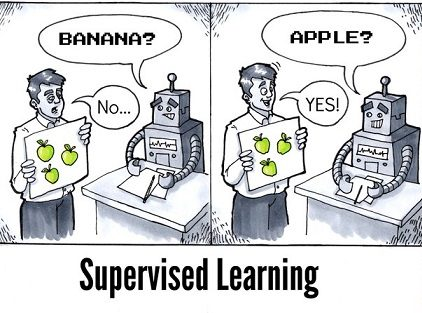


## Content

The goal of this walkthrough is to provide you with insights on classification, focusing on one technique called logistic regression. After presenting the main concepts, you will be introduced to the techniques to implement the algorithms in Python. Finally, it will be your turn to practice, using an application on forest fires. 

This notebook is organized as follows:
- [Background](#Background)
    - [Objective](#Objective)
    - [Examples of classification](#Examples-of-classification)
    - [Logistic regression model](#Logistic-regression-model)
        - [Logistic Loss function](#Logistic-Loss-function)
- [Implementation](#Implementation)
    - [Load and discover dataset](#Load-and-discover-dataset)
    - [Splitting the dataset](#Splitting-the-dataset)
    - [Rescaling](#Rescaling)
    - [Building and training our classifier](#Building-and-training-our-classifier)
    - [Using the classifier to make prediction](#Using-the-classifier-to-make-prediction)
    - [Evaluating our classifier](#Evaluating-our-classifier)
        - [Accuracy](#Accuracy)
        - [Confusion matrix](#Confusion-matrix)
        - [Precision and Recall](#Precision-and-Recall)
   - [Adding cross-validation](#Adding-cross-validation)
   - [Visualizing our model: Decision boundary](#Visualizing-our-model:-Decision-boundary)
- [Your turn](#Your-turn)

## Background

### Objective

We now move from regression another important branch of machine learning: classification. As the name indicates, the idea is to classify items of a dataset into **predefined classes** for which labelled data is already available.

Classification is similar to regression, but instead of predicting a continuous target, classification algorithms attempt to apply a discrete number of labels or classes to each observation. 

While in a regression the targets are generally numerical and continuous-valued, oftentimes the targets in classification are categorical.  

However, classification can be applied in settings where the target is numerical. For example, we might want to predict whether the unemployment rate for a country will be low, medium, or high, but do not care about the actual number. In such cases, determining the "optimal" way to categorize our target variable might require some creativity, and it is important to properly justify our assumptions. 

Finally, note that many problems can be written either as classification or regression. Hence, many ML algorithms have variants that perform regression or classification tasks.

### Examples of classification

- Image classification: e.g., is this a cat or not?
- Audio classification: identify bird species from birdsong
- Labeling emails: is it a spam or not? 
- Risky or safe loan application: should a bank provide a loan to applicant or not?
- Prediction of customer behaviour: will a customer buy this new product or not?  
- Prediction of economic performance of a country: will there be a recession or not?  
- etc.

### Logistic regression model

Suppose we have *n* observations of an outcome $\boldsymbol{y}$ and *d* associated features $\boldsymbol{x_1}$, $\boldsymbol{x_2}$, ... , $\boldsymbol{x_d}$ (note that $\boldsymbol{y}$, $\boldsymbol{x_1}$, ..., $\boldsymbol{x_d}$ are vectors):

| | Outcome | Feature 1 | Feature 2 | ... | Feature d |
|:-------|:----------:|:----------:|:----------:|:----------:|:----------:|
| Observation 1 | $y_1$ | $x_{11}$ | $x_{12}$ | ... | $x_{1d}$ |
| Observation 2 | $y_2$ | $x_{21}$ | $x_{22}$ | ... | $x_{2d}$ |
| ... | ... | ... | ... | ... | ... |
| Observation n | $y_n$ | $x_{n1}$ | $x_{n2}$ | ... | $x_{nd}$ |

We will focus on binary classification for now. In other words, our outcome can take two values, 0 and 1, which represent two classes (e.g., cat or dog, spam email or not, risky or safe loan, etc.).

Remember when we did multivariate linear regression, we assumed that our model function $f_{\text{mv}}$, i.e., our prediction, was a linear combination of our features. For each observation $i$, we assumed:
$$f_{\text{mv}}(\boldsymbol{X_{i*}}, \boldsymbol{w}):=w_0 + w_1 x_{i,1} +  w_2 x_{i,2} + ... +  w_d x_{i,d}$$
with $\boldsymbol{w}=(w_0, w_1, ..., w_d)$ the vector of weights, and $\boldsymbol{X}=[\boldsymbol{x_1}$, ... , $\boldsymbol{x_d}]$ the matrix of feature variables.

For each observation, our true outcome was $y_i = f_{\text{mv}}(\boldsymbol{X_{i*}}, \boldsymbol{w}) + \epsilon_i$, and our goal was to minimize the errors. 

In this setting, our model function $f_{\text{mv}}$ can take any values. It is thus suited when our outcome is continuous. However, with binary classification, we are dealing with discrete values, and more precisely with 0 and 1. How can we modify our model to obtain better prediction?

The idea of logistic regression is to transform the predictions obtained with a linear regression such that the predictions are between 0 and 1. To do so, we rely on the [Sigmoid (logistic) function](https://en.wikipedia.org/wiki/Sigmoid_function):

$$S(x) = \frac{1}{1 + e^{-x}}$$

<center>
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1280px-Logistic-curve.svg.png' width="300">
</center>

Source: Qef, from [Wikipedia Logistic Curve plot](https://commons.wikimedia.org/wiki/File:Logistic-curve.svg)

With logistic regression, we apply the sigmoid function to the output of the multivariate regression model. Let $f_{\text{logi}}$ be the prediction function of a logistic regression, we have:

$$f_{\text{logi}}(\boldsymbol{X_{i*}}, \boldsymbol{w}):= \frac{1}{1 + e^{-(w_0 + w_1 x_{i,1} +  w_2 x_{i,2} + ... +  w_d x_{i,d})}}$$

$f_{\text{logi}}$ represents the probability that a given observation belongs to class 1, i.e., $y_i=1$:
- We predict that the observation belongs to class 1 when $f_{\text{logi}}(\boldsymbol{X_{i*}}, \boldsymbol{w}) \geq 0.5$, i.e., when $w_0 + w_1 x_{i,1} +  w_2 x_{i,2} + ... +  w_d x_{i,d} \geq 0$;
- Reciprocally, we predict that the observation belongs to class 0 when $f_{\text{logi}}(\boldsymbol{X_{i*}}, \boldsymbol{w})<0.5$, i.e., $w_0 + w_1 x_{i,1} +  w_2 x_{i,2} + ... +  w_d x_{i,d}<0$.

Now our problem is the same as before: we want to minimize the errors of our model, learning the weights $w_0$, $w_1$, ..., $w_d$ from our data. To do so, we are minimizing our loss function... but which one? We will explore one option below.

*Note*: In the case of multiclass logistic regression, the idea is the same: we need to transform the output of our multivariate model. However, instead of using the sigmoid function, we are applying the [Softmax function](https://en.wikipedia.org/wiki/Softmax_function), a generalization of the sigmoid function.  

#### Logistic Loss function 

For linear regression, we used the Least Squared Error as loss function:

$$ \min_\boldsymbol{w} \sum_{i=1}^n (y_i - f_{\text{mv}}(\boldsymbol{X_{i*}}, \boldsymbol{w}))^2 $$

Can we use the same for logistic regression? No! Indeed, using Least Squared Error with our new prediction function $f_{\text{mv}}$ would result in a non-convex graph, which is not ideal for our minimization problem since we could be stuck in local minima:

<center>
<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/1*3o9_XoQP4TaceYPRZVHlxg.png' width="300">
</center>

Source: Issam Laradji, [Non-convex Optimization](https://www.cs.ubc.ca/labs/lci/mlrg/slides/non_convex_optimization.pdf)

So which loss function can we use? Ideally, we want to assign more punishment when predicting 1 while the actual value is 0 and when predicting 0 while the actual value is 1. One such function is the... **Logistic Loss**:

$$L(\boldsymbol{y}, \boldsymbol{X}, \boldsymbol{w})= -\frac{1}{n} \sum_{i=1}^n [y_i \log(f_{\text{logi}}(\boldsymbol{X_{i*}}, \boldsymbol{w})) + (1-y_i) \log(1-f_{\text{logi}}(\boldsymbol{X_{i*}}, \boldsymbol{w}))] $$

Let's decompose our function to understand a bit more how it works. For each observation $i$, the cost is: 

$$\text{Cost}_i = - y_i \log(f_{\text{logi}}(\boldsymbol{X_{i*}}, \boldsymbol{w})) - (1-y_i) \log(1-f_{\text{logi}}(\boldsymbol{X_{i*}}, \boldsymbol{w}))$$

- When $y_i = 1$, $\text{Cost}_i = - \log(f_{\text{logi}}(\boldsymbol{X_{i*}}, \boldsymbol{w}))$. Hence, if our predicted probability is 1, we have $\text{Cost}_i=0$, i.e., no cost. However, when our predicted probability is approaching 0, our cost goes to infinity (because the logarithm goes to minus infinity when we get closer to zero).
- When $y_i = 0$, $\text{Cost}_i = - \log(1-f_{\text{logi}}(\boldsymbol{X_{i*}}, \boldsymbol{w}))$, and it works the other way around. If our predicted probability is zero, the cost is zero, but when our predicted probability is approaching 1, our cost goes to infinity.

<center>
<img src='https://miro.medium.com/v2/resize:fit:1400/format:webp/1*_NeTem-yeZ8Pr9cVUoi_HA.png' width="400">
</center>

Source: Shuyu Luo, [Loss Function (Part II): Logistic Regression](https://towardsdatascience.com/optimization-loss-function-under-the-hood-part-ii-d20a239cde11)

The Logistic Loss not only punishes errors with a very large cost, it is also convex. Hence, we can still apply Gradient Descent, Newton's Method, and other optimization algorithms!

To learn more:
- [Loss Function (Part II): Logistic Regression](https://towardsdatascience.com/optimization-loss-function-under-the-hood-part-ii-d20a239cde11), by Shuyu Luo, Published in Towards Data Science
- [Understanding the log loss function](https://medium.com/analytics-vidhya/understanding-the-loss-function-of-logistic-regression-ac1eec2838ce), by Susmith Reddy, Published in Analytics Vidhya


## Implementation

We are already familiar with the **sklearn** library, when we implemented regression algorithms last week ([Documentation](https://scikit-learn.org/stable/index.html)). We will keep on using this library to implement a logistic regression.

For the walkthough we will use a **dataset on wine quality**. As usual, you can find it in the /data folder.

<img src='https://assets.pbimgs.com/pbimgs/rk/images/dp/wcm/202145/0002/schott-zwiesel-classico-wine-glasses-c.jpg' width="300">

The wine data set consists of 11 different parameters of wine such as alcohol content, acidity, and pH, which were measured for several wine samples from the North of Portugal.

Source: P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In *Decision Support Systems*, Elsevier, 47(4):547-553, 2009. Dataset obtained from UCI Machine Learning repository, [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/wine+quality). 

These wines were derived from different cultivars; therefore there have different quality, as a score between 0 and 10. We grouped the wines into two quality classes: 0 and 1, representing respectively  "poor quality" (score 0-5), and "good quality" (score 6-10).

Our goal here is to find a model that can predict the class of wine given the 11 measured parameters, and find out the major differences among the two classes.

Ok, let's go!

### Load and discover dataset

In [2]:
#Load the dataset
url = "https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/wine-quality-red.csv"
wines = pd.read_csv(url).drop_duplicates().dropna() # drop duplicates and NaN values

# Display a sample of the data
display(wines.head())

# Print columns
print(wines.columns.values)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,1
5,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,0


['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH'
 'sulphates' 'alcohol' 'quality']


Note that we only have numerical variables, and thus won't need to encode categorical variables. 

However, we will need to rescale our features since, for instance, chlorides values are lower than 1 while sulfur dioxide can attain a value of 289:

In [3]:
wines.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.894040,46.826343,0.996709,3.309787,0.658705,10.432315,0.529065
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447595,33.409287,0.001869,0.155036,0.170667,1.082065,0.499338
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,1.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,1.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,1.000000


We now define our features - all wine parameters - and our target variable - the wine quality:

In [4]:
# Define features and target variable
X = wines.drop(columns='quality')
y = wines['quality']

We know check how many observations we have for each class:

In [5]:
# Count the number of observations (rows) corresponding to each value 
y.value_counts()

quality
1    719
0    640
Name: count, dtype: int64

We have 719 "good" wines and 640 "poor" quality wines. The number of observations for each class influence the quality of our predictions. Here, our dataset is reasonably balanced.

### Splitting the dataset

As always, the first step is to split our data into random training and test subsets. Recall that the training set is used to learn the parameters of our model while the test set is used to evaluate our predictions.

We use the `train_test_split` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)) of sklearn, imported with the following line of code (already done at the beginning of the notebook):

```python
from sklearn.model_selection import train_test_split 
```

The test size here is of 25% of the original data.

In [6]:
#Split data set into a train and a test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=True)

print(f"The training set has {X_train.shape[0]} observations, and the test set has {X_test.shape[0]} observations.")

The training set has 1019 observations, and the test set has 340 observations.


### Rescaling

When we have a dataset with features that have very distinct ranges, we might get biased results. We want the features to be in the same or similar range, which also helps the interpretation of the model parameters (weights). 

We therefore **normalize** the data. It involves transforming all values for a specific attribute so that they fall within a small specified range. We can use `StandardScaler()`, ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)) `MinMaxScaler()` ([Documentation](https://scikit-learn.org/0.15/modules/generated/sklearn.preprocessing.MinMaxScaler.html)) or others for normalization.

In our example we will normalize both our **train AND test data** using `MinMaxScaler()`. Here is the import line:

```python
from sklearn.preprocessing import MinMaxScaler
```

For each observation $x_{ij}$, with $i$ the observation (row) and $j$ the feature (column), the MinMax Scaler applies the following transformation:  
$$x_{scaled,ij}=\frac{x_{ij} - \min(\boldsymbol{x_j})}{\max(\boldsymbol{x_j})-\min(\boldsymbol{x_j})}$$

**IMPORTANT**: When you normalize the train data, you need to do the same modification (here normalization) to the test data. In other words, you train your scaler on your training set, and apply the same transformation to the training and test set.

In [7]:
# Define the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(X_train) # here the scaler learns the min and max of each attribute from the training set

# Transform the train and the test set
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Note that the fit and transform steps can be merged into one for the training set:
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

### Building and training our classifier

To predict the class of our target variable we use a logistic regression. The sklearn module is called `LogisticRegression()` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)). Here is the import line:

```python
from sklearn.linear_model import LogisticRegression
```

Note that L2-regularization is applied by default. By specifying the argument *penalty*, you can specify the regularization techniques, namely 'l1', 'l2', 'elasticnet', or None. 

You can also specify the *solver*. By default, 'lbfgs' is used, which stands for [Limited-memory Broyden–Fletcher–Goldfarb–Shanno](https://en.wikipedia.org/wiki/Limited-memory_BFGS). 
Note that the choice of the algorithm depends on the penalty chosen. You can refer to the documentation for insights on the choice of solver/penalty depending on your problem and data.

**A short note on solver:**
L-BFGS approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm ([BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm)), which is based on [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization), an alternative to Gradient Descent. While the Gradient Descent rely on the gradient (first-order derivatives) to update our parameters, Newton's method also makes use of the [Hessian matrix](https://en.wikipedia.org/wiki/Hessian_matrix), i.e., the second-order derivatives. Newton's method generally converges faster than Gradient Descent. However, Newton's method is computationally-expensive and the Hessian might not even exist. Hence, numerical methods called [Quasi-Newton](https://en.wikipedia.org/wiki/Quasi-Newton_method), such as BFGS, have been developed to solve optimization problems.  

In [8]:
# 1. Set up our model
model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)

# 2. Fit our model
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

After fitting the model, we can easily retrieve the values of the different weights coefficients: the intercept with `.intercept_`, and the weights of each feature with `.coef_.flatten()`:

In [9]:
# Dataframe with the intercept and coefficients (weights) of the logistic model
model_coeff = pd.DataFrame(np.concatenate((model.intercept_, model.coef_.flatten())), 
                     index=["Intercept"] + list(X.columns.values),
                     columns=['Coefficients logistic model'])
model_coeff

,Coefficients logistic model
Intercept,-0.359187
fixed acidity,0.832102
volatile acidity,-3.234682
citric acid,-0.156783
residual sugar,0.941071
chlorides,-1.092865
free sulfur dioxide,0.862756
total sulfur dioxide,-2.152866
density,-0.730691
pH,-0.099199


It seems like the level of alcohol and volatile acidity were the most important features to predict the wine quality, at least in our model.

### Using the classifier to make prediction

Once our model has been trained, we can use `predict()` to predict new values. We predict the values from the test set to then evaluate the model, estimating the accuracy of our classifier.

In [10]:
y_pred = model.predict(X_test)

We can even access the probabilities that one observation belongs to one class or the other with `predict_proba()`. The largest probability determines the predicted class.

In [11]:
# Dataframe with probabilities that our first 5 observations belong to each class
model_proba = pd.DataFrame(model.predict_proba(X_test)[0:4], 
                     columns=['Probability poor-quality wine', 'Probability good wine'])
model_proba

,Probability poor-quality wine,Probability good wine
0,0.196935,0.803065
1,0.805026,0.194974
2,0.614734,0.385266
3,0.571484,0.428516


###  Evaluating our classifier

We will now evaluate the performance of our classifier using several metrics.

#### Accuracy

Perhaps the most intuitive classification metric is *accuracy*, which is the fraction of correct vs total predictions:

$$ \mathrm{Accuracy} = \frac{\# \mathrm{\, correct \, predictions}}{\# \mathrm{\, total \, predictions}} $$

For a sklearn classifier, this can be computed using the `score` method.

In [12]:
# Accuracy on the test set
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(model.score(X_test, y_test)))

# Accuracy on the training set
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(model.score(X_train, y_train)))

Accuracy of Logistic regression classifier on test set: 0.72
Accuracy of Logistic regression classifier on training set: 0.74


Alternatively, we could use the `accuracy_score` module, imported with the following line of code:

```python
from sklearn.metrics import accuracy_score
```

In [13]:
accuracy_test = accuracy_score(y_test, y_pred)

print(f'Accurary of Logistic regression classifier on test set: {accuracy_test :.2f}')

Accurary of Logistic regression classifier on test set: 0.72


When the testing accuracy is much lower than the training accuracy, we have an overfitting issue. Reciprocally, when the testing accuracy is similar to or higher than the training accuracy, the model might be underfitting, and we could consider either using a more powerful model or adding additional
features.

Our testing accuracy is 72%. Is that good? It depends! The quality of our prediction depends on the distribution of class in our original data:

In [14]:
y.value_counts().plot.bar(color=['purple', 'blue'], grid=False)
plt.ylabel('Number of observations')
plt.title('Number of observations of each class in the wine dataset');

Imagine we have a naive classifier that always predict the majority class. We call the default rate (or base rate) the accuracy of this classifier, which is equal to the size of the most common class over the size of the full dataset:

$$\text{Default rate} = \frac{\# \text{ most frequent class}}{\# \text{ total observations}}$$

If the default rate is too high, then the classification can be biased, meaning that the data set has too many observations of one class compared to the other classes, and has hence more impact on the classification results. 

The accuracy of our classifier should be better than the default rate. Let's calculate this default rate!

In [15]:
# Compute the default rate
quality_0 = wines.loc[wines["quality"] == 0].shape[0]
print('# occurrence of class 0: ', quality_0)
quality_1 = wines.loc[wines["quality"] == 1].shape[0]
print('# occurence of class 1: ', quality_1)
defaultrate = max(quality_0, quality_1)/(wines["quality"].shape[0])
print(f'Default rate = {defaultrate:0.4f}')

# occurrence of class 0:  640
# occurence of class 1:  719
Default rate = 0.5291


Our default rate is about 52.9% while our classifier accuracy is 72.4%. Not too bad!

#### Confusion matrix

The confusion matrix allows us to get more details on the performance of our model. It will allow us to see what our classification model is getting right and what types of errors it is making.

Here is how a confusion matrix looks like: 

|   | Class 0 predicted  | Class 1 predicted  |    
|---|---|---|
| **Class 0 actual**  |  TN |FP   |    
| **Class 1 actual**  | FN  | TP  |   


where TP = true positive, FN = false negative, FP = false positive and TN = true negative. Here class 1 is considered the "True" class.

We are using the `confusion_matrix` module of sklearn, imported with the following line of code:

``` python
from sklearn.metrics import confusion_matrix
```

It requires as input the true values and the predicted values:

In [16]:
confusion_matrix(y_test, y_pred)

array([[113,  45],
       [ 49, 133]])

To obtain a more visual representation, we will use `heatmap` from the `seaborn` library:

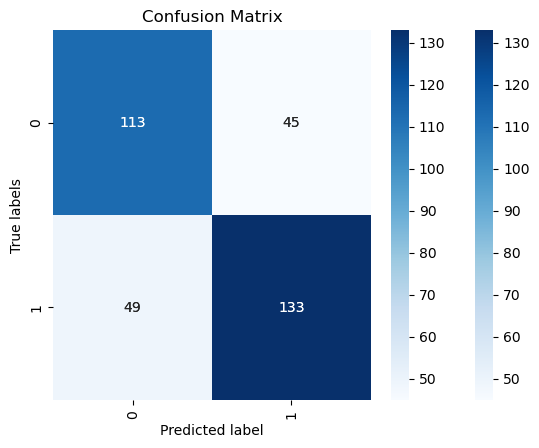

In [19]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='.4g')
plt.xlabel('Predicted label')
plt.ylabel('True labels')
plt.title('Confusion Matrix');
plt.show()

On the diagonal of the confusion matrix are our correct predictions, while the off-diagonal elements are incorrect predictions. We can thus quickly identify whether one class is driving down or up the accuracy results, or if the results are more balanced. 

Recall that the accuracy is the number of correct predictions divided by the number of incorrect predictions. Thus, the accuracy is the sum of the diagonal elements of the confusion matrix, divided by the total number of elements:

In [20]:
print('Accuracy on test set using sklearn: {:.6f}'.format(accuracy_score(y_test, y_pred)))
print('Accuracy on test set by hand: {:.6f}'.format((113+133)/(113+133+45+49)))

Accuracy on test set using sklearn: 0.723529
Accuracy on test set by hand: 0.723529


#### Precision and Recall

In many contexts, the accuracy would be an appropriate way to evaluate a model, but in others, this would be insufficient.

For example, suppose we want to use a classification model to predict the likelihood of someone having a rare, but serious health condition. If the condition is very rare (say it appears in 0.01% of the population), then a model that always predicts false would have 99.99% accuracy, but the false negatives could have large consequences. 

To capture such situations, we often use two other very common metrics: the *precision* and *recall*.

Let class 1 represents our positive cases ("true" class), the confusion matrix is: 

|   | Class 0 predicted  | Class 1 predicted  |    
|---|---|---|
| **Class 0 actual**  |  TN | FP   |    
| **Class 1 actual**  | FN  | TP  | 

- *Precision*: The number of true positives over the number of positive  predictions. Precision tells us how often the model was correct when it predicted true.

$$\text{Precision} = \frac{\# \text{ true positives}}{\# \text{ predicted positives}} = \frac{ \text{TP}}{\text{TP+FP}}$$

- *Recall*: The number of true positives over the number of actual positives. Recall answers the question, “What fraction of the positives did we get correct?”  

$$\text{Recall} = \frac{\# \text{ true positives}}{\# \text{ actual positives}} = \frac{\text{TP}}{ \text{TP+FN}}$$ 

In many settings, both precision and recall are equally important and a compound metric known as the *F1-score* is used:

$$\text{F1} = 2 \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}$$

The F1 score is bounded between 0 and 1. It will only achieve a value of 1 if both precision and recall are exactly 1.

We will compute the precision using `precision_score` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)), the recall using `recall_score` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)), and the F1 score using `f1_score` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)). Here are the import lines:

``` python
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
```

For a binary classifier, all metrics will report by default the scores associated with the positive class (i.e., with observations equal to 1). If we are interested in the results for another class, we can specify some parameters. For instance, the parameter `average = None` will return the scores of each class: 

In [21]:
print('The precision for class 1 (good wines) is: {:0.3f}'.format(precision_score(y_test, y_pred)))
print('The recall for class 1 is: {:0.3f}'.format(recall_score(y_test, y_pred)))
print('The F1 score for class 1 is: {:0.3f}'.format(f1_score(y_test, y_pred)))

The precision for class 1 (good wines) is: 0.747
The recall for class 1 is: 0.731
The F1 score for class 1 is: 0.739


In [22]:
# Precision of each class
model_precision = precision_score(y_test, y_pred, average = None)
# Recall of each class
model_recall = recall_score(y_test, y_pred, average = None)
# F1 score of each class
model_f1 = f1_score(y_test, y_pred, average = None)

# Visualize all results in a dataframe:
model_eval = pd.DataFrame([model_precision, model_recall, model_f1],
                    index = ['Precision', 'Recall', 'F1 score'], 
                    columns=['Class 0', 'Class 1'])
model_eval

,Class 0,Class 1
Precision,0.697531,0.747191
Recall,0.715190,0.730769
F1 score,0.706250,0.738889


Evaluating your classifier is key, and it depends on our objectives and on our data. You can find all the sklearn model evaluation metrics [here](https://scikit-learn.org/stable/modules/model_evaluation.html).

### Adding cross-validation

We will see how the performance of our model evolves when implementing cross-validation technique. We are using the `LogisticRegressionCV()` module ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)), imported as follows:

```python
from sklearn.linear_model import LogisticRegressionCV
```

In [23]:
# Set up our model
model_cv = LogisticRegressionCV(penalty='l2', solver='lbfgs', cv=5, max_iter=1000)

# Fit our model
model_cv.fit(X_train, y_train)

LogisticRegressionCV(cv=5, max_iter=1000)

Let's check the accuracy of our new model and compare it to the previous one:

In [24]:
# Accuracy on the test set
model_cv_test_accuracy = model_cv.score(X_test, y_test) # Cross-validation model
model_test_accuracy = model.score(X_test, y_test)       # Logistic regression
# Accuracy on the training set
model_cv_train_accuracy = model_cv.score(X_train, y_train) # Cross-validation model
model_train_accuracy = model.score(X_train, y_train)       # Logistic regression
# Gather results in a dataframe:
models_accuracy = [[model_cv_test_accuracy, model_test_accuracy], 
                   [model_cv_train_accuracy, model_train_accuracy]]
model_compar = pd.DataFrame(models_accuracy,
                    index = ['Test accuracy', 'Train accuracy'], 
                    columns=['Cross-validation model', 'Logistic regression'])
model_compar

,Cross-validation model,Logistic regression
Test accuracy,0.726471,0.723529
Train accuracy,0.750736,0.744848


The accuracy improved a bit. Let's have a look at the confusion matrix:

In [25]:
# Confusion matrix
confusion_cv = confusion_matrix(y_test, model_cv.predict(X_test))
# Heatmap of confusion matrix
sns.heatmap(confusion_cv, annot=True, cmap='Blues', fmt='.4g')
plt.xlabel('Predicted label')
plt.ylabel('True labels')
plt.title('Confusion Matrix with Cross Validation');

We correctly predicted one additional observation from the class 0. Not a spectacular improvement but we'll take it!

### Visualizing our model: Decision boundary

Let's build a new classifier, only using two features, namely alcohol and volatile acidity. Our objective is to visualize the decision boundary, i.e., the line that splits our two classes.

In [26]:
# Extract features of interest
X2 = X[['volatile acidity', 'alcohol']]

# Split data set into a train and a test data sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y, test_size=0.25, random_state=0, shuffle=True)

# Set up our model
model_2 = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)

# Fit our model
model_2.fit(X_train_2, y_train_2)

# Compute accuracy
print('Accuracy of two-features classifier on test set: {:.2f}'
     .format(model_2.score(X_test_2, y_test_2)))
print('Accuracy of two-features classifier on training set: {:.2f}'
     .format(model_2.score(X_train_2, y_train_2)))

# Dataframe with the intercept and coefficients (weights) of the model
model_2_coeff = pd.DataFrame(np.concatenate((model_2.intercept_, model_2.coef_.flatten())), 
                     index=["Intercept"] + list(X2.columns.values),
                     columns=['Coefficients 2-features model'])
model_2_coeff

Accuracy of two-features classifier on test set: 0.70
Accuracy of two-features classifier on training set: 0.75


,Coefficients 2-features model
Intercept,-9.877193
volatile acidity,-2.975103
alcohol,1.123422


We now plot the decision boundary. 

Note that the decision boundary represents the points for which the probability to belong to class 0 is the same as the probability to belong to class 1. For such points, we have:

$$w_0 + w_1 x_{i1} + w_2 x_{i2} =0 $$

Reorganizing, we get:

$$x_{i2} = - \frac{w_0 + w_1 x_{i1}}{w_2}$$

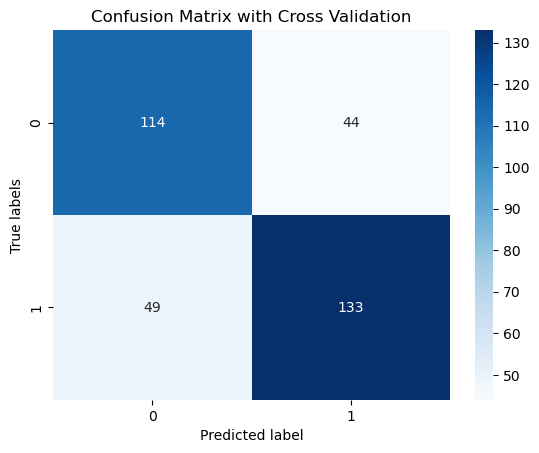

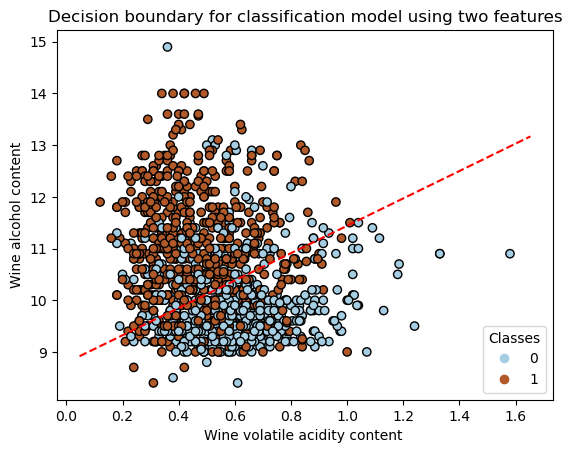

In [27]:
fig, ax = plt.subplots()

# Scatter plot of volatile acidity and alcohol, colored by their class
scatter = ax.scatter(X2['volatile acidity'].values,  # values of volatile acidity on x-axis
            X2['alcohol'].values,                    # values of alcohol on y-axis
            c=y,                   # color class by class 
            edgecolors='k',        # black edge colors
            cmap=plt.cm.Paired)    # color of markers: Paired colormap 

# Plot decision boundary 
x_vals = np.array(ax.get_xlim())    # array with x-axis limits
y_vals = -(model_2.intercept_[0]+x_vals*model_2.coef_[0][0])/model_2.coef_[0][1]  # equation of decision boundary
plt.plot(x_vals, y_vals, '--', c="red")  # plot decision boundary in red color

# Add labels, title, and legend
plt.xlabel('Wine volatile acidity content ')
plt.ylabel('Wine alcohol content')
plt.title('Decision boundary for classification model using two features')
plt.legend(*scatter.legend_elements(),loc="lower right", title="Classes")

# Display plot
plt.show()

Let's interpret this graph. The red doted line shows the boundary between the two regions. Each observation above the line will belong to class 1, i.e., good wine, while each observation below the line will belong to class 0, i.e., poor quality wine. Furthermore, the closer a point is to the decision region boundary the more uncertain we are about the accuracy of the classification. 

Let's test this, by creating two new points:
- point A will have a volatile acidity of 1.2 and an alcohol content of 11.5
- point B will have the same volatile acidity, but an alcohol content of 13

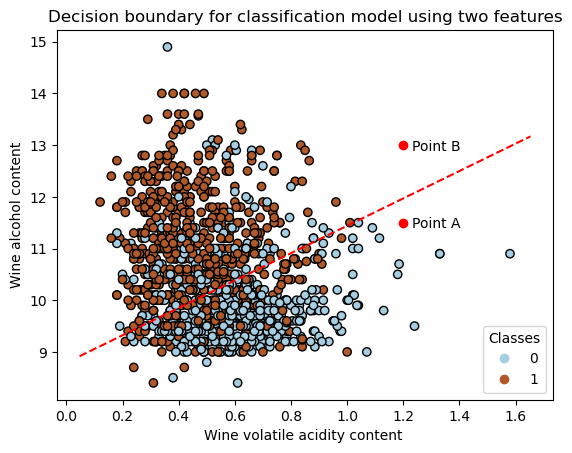

In [28]:
fig, ax = plt.subplots()

# Scatter plot of volatile acidity and alcohol, colored by their class
scatter = ax.scatter(X2['volatile acidity'].values,  # values of volatile acidity on x-axis
            X2['alcohol'].values,                    # values of alcohol on y-axis
            c=y,                   # color class by class 
            edgecolors='k',        # black edge colors
            cmap=plt.cm.Paired)    # color of markers: Paired colormap 

# Plot decision boundary 
x_vals = np.array(ax.get_xlim())    # array with x-axis limits
y_vals = -(model_2.intercept_[0]+x_vals*model_2.coef_[0][0])/model_2.coef_[0][1]  # equation of decision boundary
plt.plot(x_vals, y_vals, '--', c="red")  # plot decision boundary in red color

# Add new points
plt.scatter(1.2, 11.5, c='red') # Point A
plt.scatter(1.2, 13, c='red')   # Point B
plt.text(1.23, 11.4, 'Point A')  # Point A label
plt.text(1.23, 12.9, 'Point B')       # Point B label

# Add labels, title, and legend
plt.xlabel('Wine volatile acidity content ')
plt.ylabel('Wine alcohol content')
plt.title('Decision boundary for classification model using two features')
plt.legend(*scatter.legend_elements(),loc="lower right", title="Classes")

# Display plot
plt.show()

We predict the class of each point:

In [29]:
# Dataframe with new points
x_new= pd.DataFrame([[1.2, 11.5], [1.2,13]], columns=['volatile acidity', 'alcohol'])

# Predicted class
print('Point A belongs to class {}.'.format(model_2.predict(x_new)[0]))
print('Point B belongs to class {}.'.format(model_2.predict(x_new)[1]))

Point A belongs to class 0.
Point B belongs to class 1.


Finally, we can check the probabilities to belong to each class:

In [30]:
# Dataframe with probabilities to belong to each class
x_new_proba = pd.DataFrame(model_2.predict_proba(x_new), 
                     index = ['A', 'B'],      
                     columns=['Class 0', 'Class 1'])
x_new_proba

,Class 0,Class 1
A,0.629008,0.370992
B,0.239182,0.760818


Point A is closer to the boundary decision line, hence, its probability to belong to class 0 (0.63) is lower than the probability of point B to belong to class 1 (0.76): the prediction is more uncertain.

## Your turn


Now it's your turn to implement a classifier! In this application, you will try to predict whether a forest fire spread and burned forest areas in the Montesinho natural park in Portugal.

We are using the [Forest Fires dataset](https://www.kaggle.com/datasets/sumitm004/forest-fire-area), created by Paulo Cortez and Aníbal Morais, and available on Kaggle.

Source: P. Cortez and A. Morais. A Data Mining Approach to Predict Forest Fires using Meteorological Data. In J. Neves, M. F. Santos and J. Machado Eds., New Trends in Artificial Intelligence, Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, December, Guimaraes, Portugal, pp. 512-523, 2007. APPIA, ISBN-13 978-989-95618-0-9.

The original dataset contains 13 columns:
- X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
- Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
- month - month of the year: "jan" to "dec" 
- day - day of the week: "mon" to "sun"
- FFMC - Fine Fuel Moisture Code (FFMC) index from the [Fire Weather Index (FWI)](https://www.nwcg.gov/publications/pms437/cffdrs/fire-weather-index-system) system: 18.7 to 96.20
- DMC - Duff Moisture Code (DMC) index from the FWI system: 1.1 to 291.3 
- DC - Drought Code (DC) index from the FWI system: 7.9 to 860.6 
- ISI - Initial Spread Index (ISI) index from the FWI system: 0.0 to 56.10
- temp - temperature in Celsius degrees: 2.2 to 33.30
- RH - relative humidity in %: 15.0 to 100
- wind - wind speed in km/h: 0.40 to 9.40 
- rain - outside rain in mm/m2 : 0.0 to 6.4 
- area - the burned area of the forest (in ha): 0.00 to 1090.84

In addition, we created a new column, "class", detailing whether the fire burned an area of forest:
- class is equal to 0 if area = 0.00 ha
- class is equal to 1 if area > 0.00 ha 

Our goal will be to predict the class using logistic regression, given the weather and FWI features.

In [31]:
# Load data
url_ff = 'https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/forestfires.csv'
forest_fire = pd.read_csv(url_ff)

### Discover your dataset

- Explore your dataset, displaying a few observations, the types of your data, some summary statistics, and the correlation matrix. Feel free to push forward your EDA using a few graphs e.g., boxplot and pairplot.

In [32]:
# YOUR CODE HERE

# Display a sample of the data
display(forest_fire.head())

# Display the data types
display(forest_fire.dtypes)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,class
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0


X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
class      int64
dtype: object

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,class
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292,0.522244
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818,0.499989
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000,1.000000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000,1.000000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000,1.000000


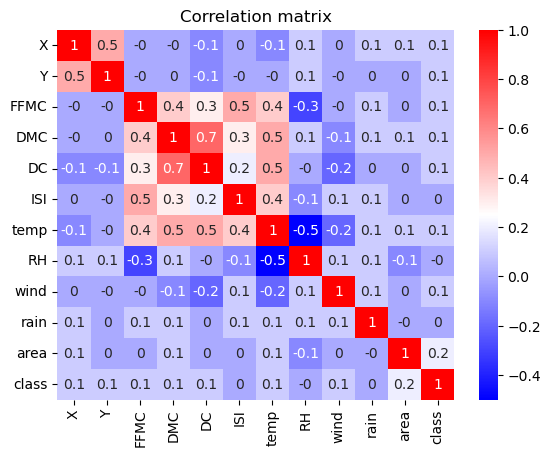

In [33]:
# Summary statistics
display(forest_fire.describe())

# Correlation matrix visualized in heat map
sns.heatmap(forest_fire.corr(numeric_only = True).round(decimals=1), annot=True, cmap="bwr")
plt.title('Correlation matrix')
plt.show()

We do a box plot of weather and fire index features, which are the features we are considering to to predict our class:

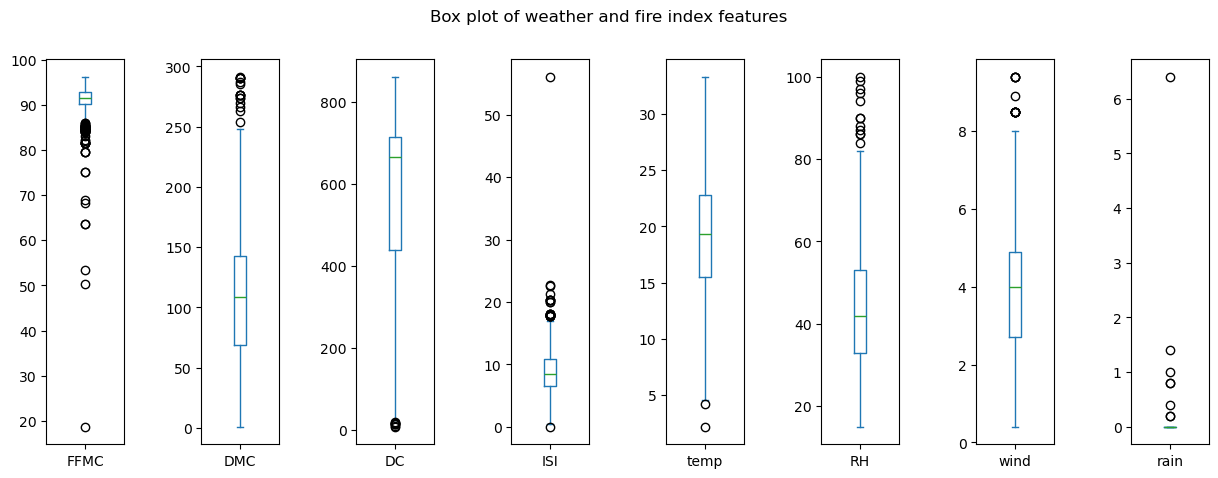

In [34]:
forest_fire[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']].plot(
    kind='box', 
    subplots=True, 
    sharey=False,
    figsize=(15, 5),
    title = 'Box plot of weather and fire index features'
)
plt.subplots_adjust(wspace=1)    # increase spacing between subplots
plt.show()

Pair plot of the same features, colored by our class to visualize if we can already identify some interesting relations:

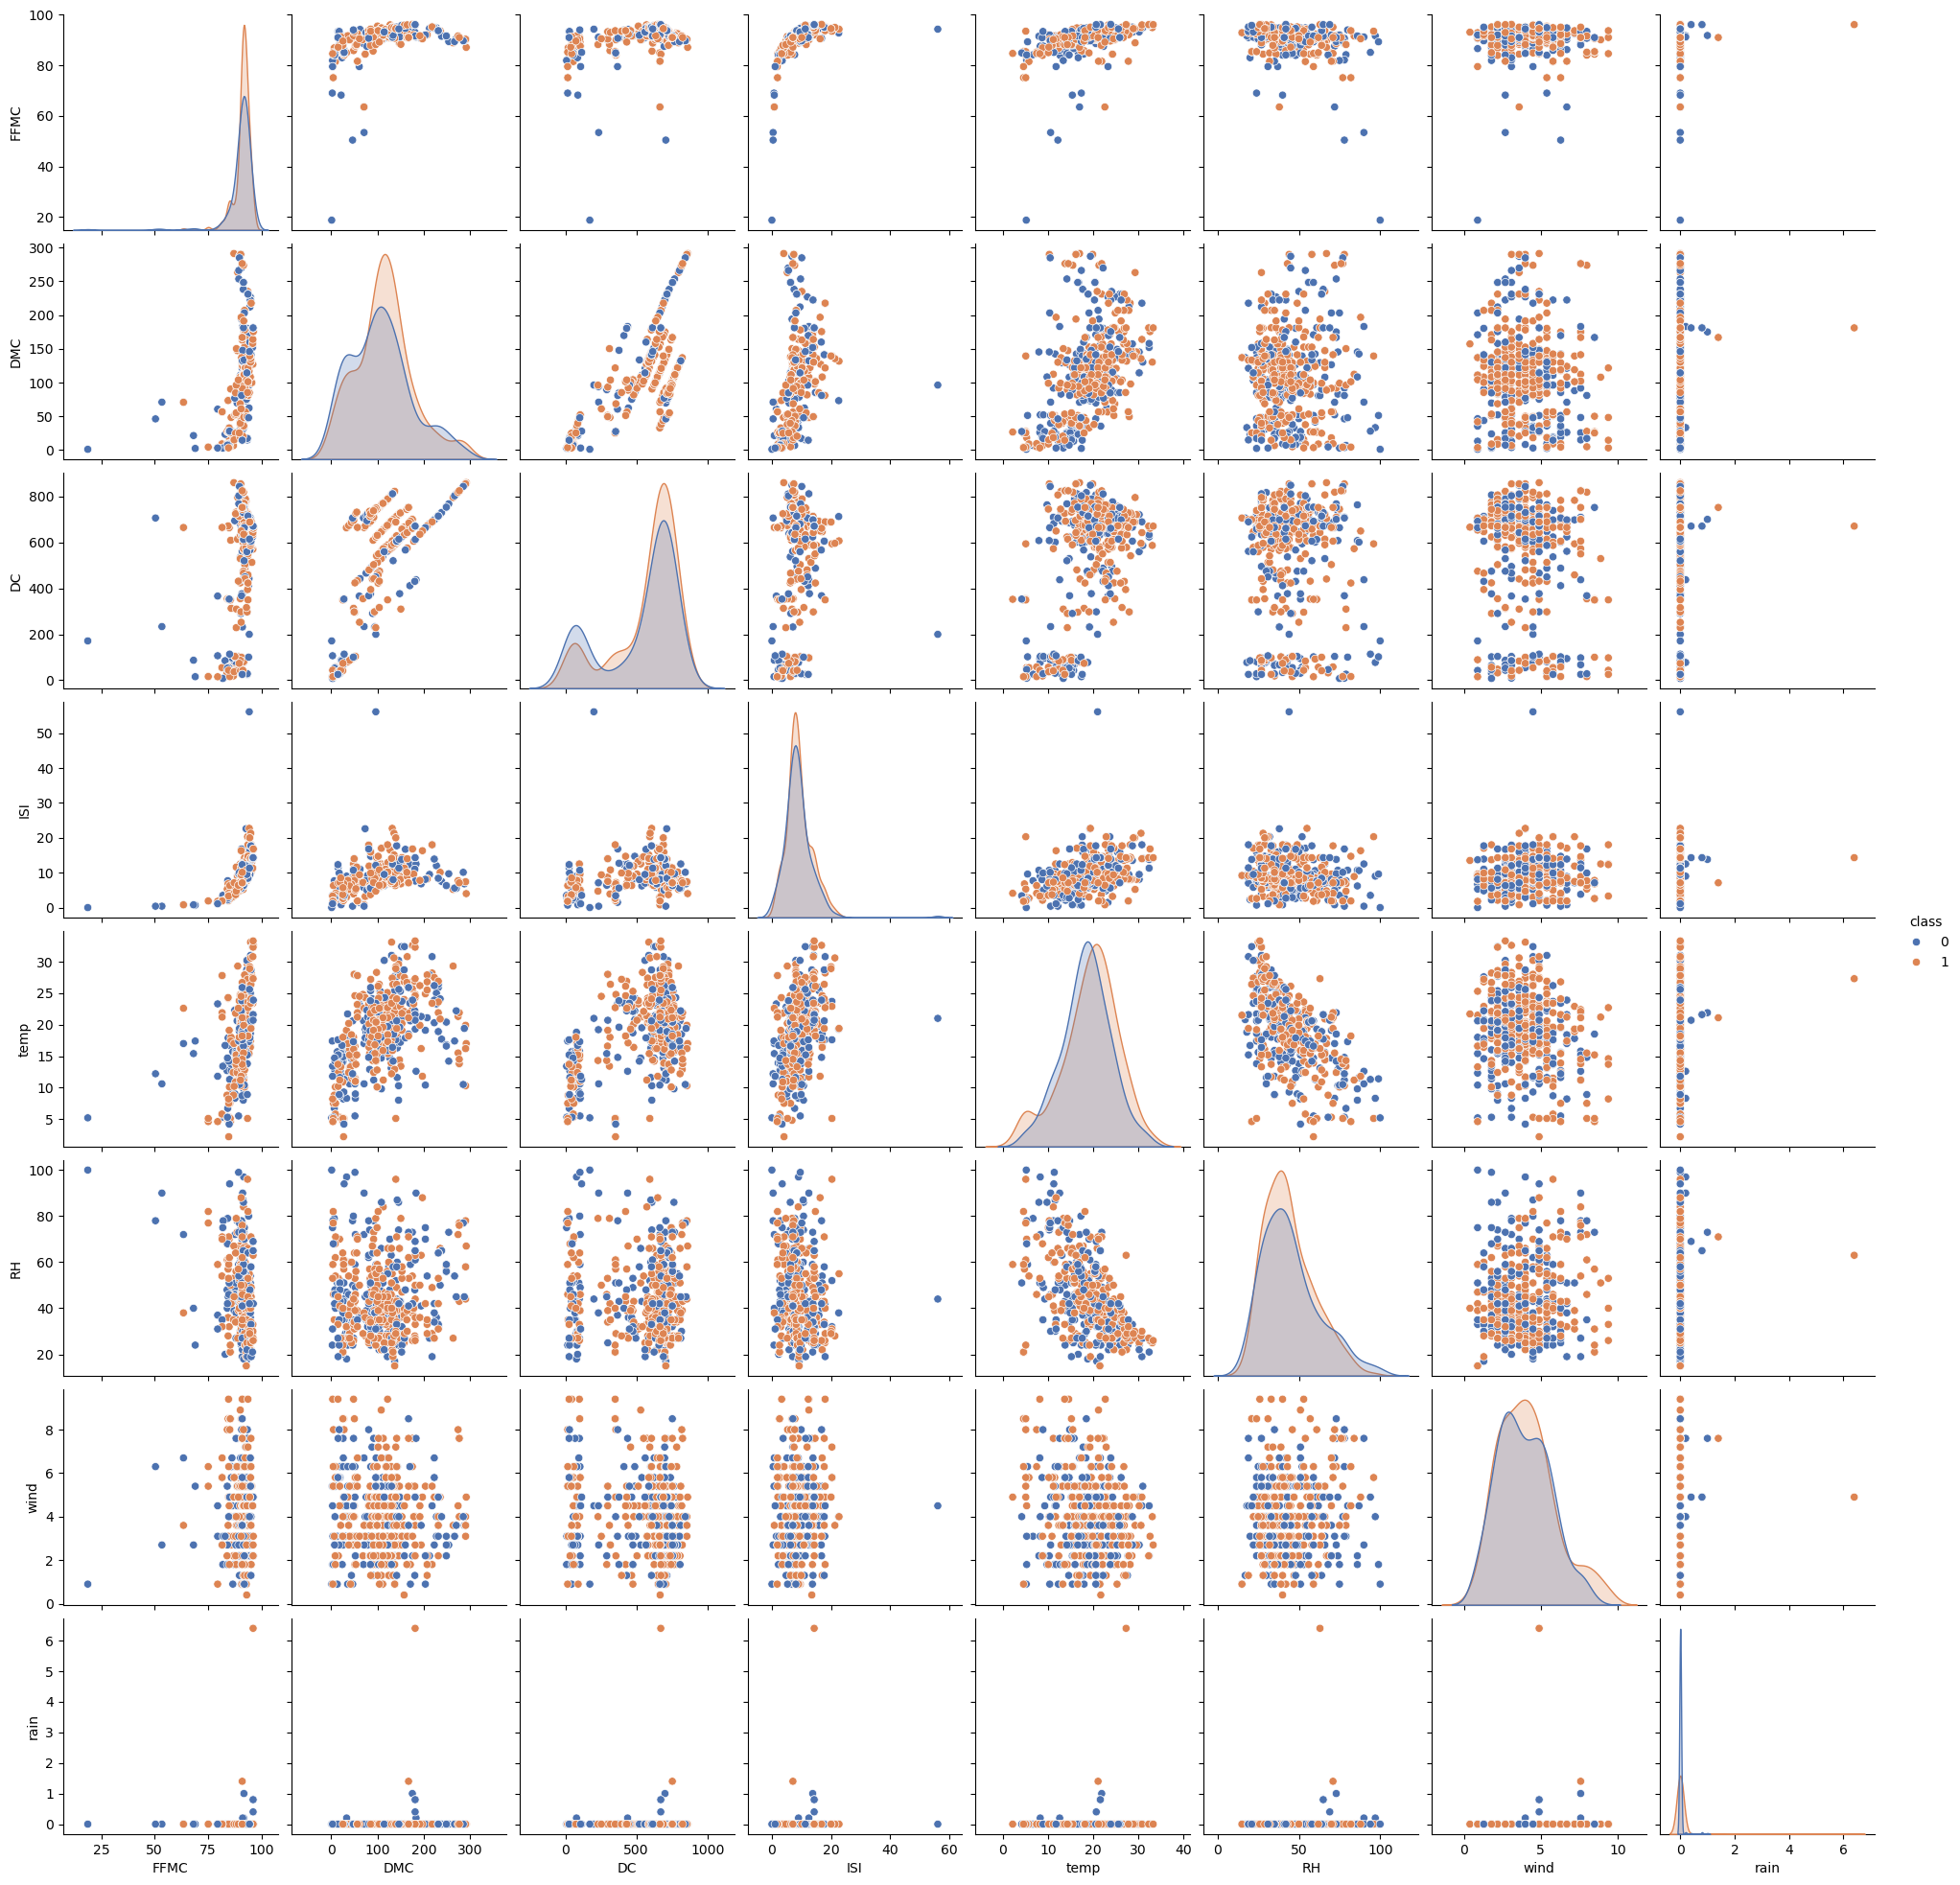

In [35]:
df_ff = forest_fire[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'class']]
sns.pairplot(df_ff,
             hue = 'class',
             palette = 'deep') 
plt.show()

From our EDA, we notice that our target variable ('class') is not much correlated with any features. The pair plot provides more details: we do not visualize any cluster, i.e., any obvious decision boundary lines. We'll see if we can still design a classifier with a good accuracy...

### Two-features logistic regression

We'll start with only two features, the temperature and wind.

- Define your features and target variable ('class'):

In [36]:
# YOUR CODE HERE

X_forest_2 =forest_fire[['temp', 'wind']]
y_forest = forest_fire[['class']]

- Split you data intro training and test set:

In [37]:
# YOUR CODE HERE

X_train_f2, X_test_f2, y_train_f2, y_test_f2 = train_test_split(X_forest_2, y_forest, 
                                                            test_size=0.2, 
                                                            random_state=9, 
                                                            shuffle=True)

- Rescale your data, using the scaler of your choice:

In [38]:
# YOUR CODE HERE

# Define the scaler
scaler_f2 = MinMaxScaler()

# Fit and transform training set
X_train_f2 = scaler_f2.fit_transform(X_train_f2) 

# Transform test set
X_test_f2 = scaler_f2.transform(X_test_f2)

- Build and train a simple logistic regression classifier:

In [39]:
# YOUR CODE HERE

# Set up our model
model_f2 = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)

# Fit our model
model_f2.fit(X_train_f2, y_train_f2.values.flatten())  # We extract values and flatten y_train_f2 to obtain an array as input instead of data frame

LogisticRegression(max_iter=1000)

- Compare the training and testing accuracy of your model

In [40]:
# YOUR CODE HERE

# Accuracy on the test set
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(model_f2.score(X_test_f2, y_test_f2)))

# Accuracy on the training set
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(model_f2.score(X_train_f2, y_train_f2)))

Accuracy of Logistic regression classifier on test set: 0.53
Accuracy of Logistic regression classifier on training set: 0.54


The accuracy seems low, which was expected following our EDA. Let's try to gather more information to better evaluate our classifier.

- Plot the distribution of class

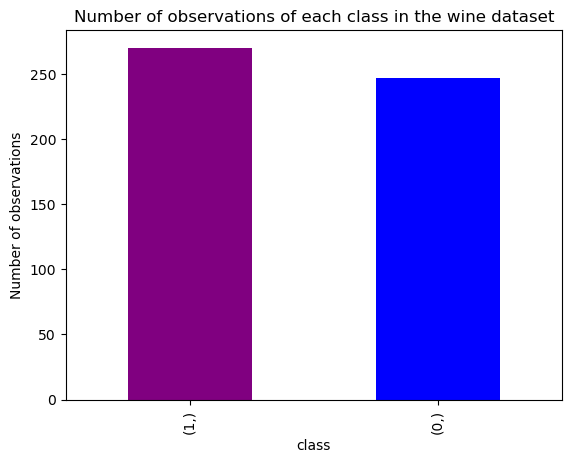

In [57]:
# YOUR CODE HERE

y_forest.value_counts().plot.bar(color=['purple', 'blue'], grid=False)
plt.ylabel('Number of observations')
plt.title('Number of observations of each class in the wine dataset');
plt.show()

- Compute the default rate and compare it to the accuracy of your model. What do you think?

In [42]:
# YOUR CODE HERE

# Compute the default rate
fire_0 = forest_fire.loc[forest_fire["class"] == 0].shape[0]
print('# occurrence of class 0: ', fire_0)
fire_1 = forest_fire.loc[forest_fire["class"] == 1].shape[0]
print('# occurence of class 1: ', fire_1)
defaultrate_f = max(fire_0, fire_1)/(forest_fire["class"].shape[0])
print(f'Default rate = {defaultrate_f:0.4f}')

# occurrence of class 0:  247
# occurence of class 1:  270
Default rate = 0.5222


The default rate is almost equal to our accuracy, so our classifier does not outperform a naive classifier that would always predict class 1...

- Plot the confusion matrix

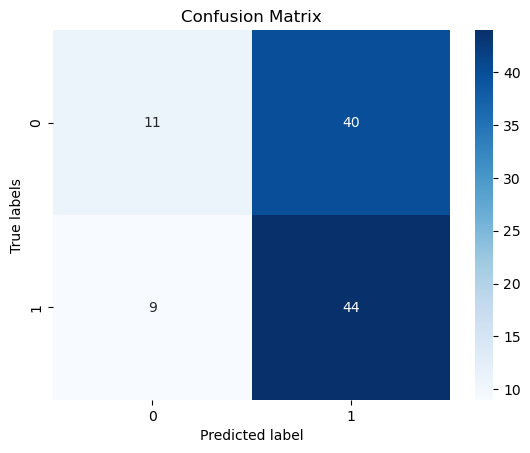

In [58]:
# YOUR CODE HERE

# Predict on test set
y_pred_f2 = model_f2.predict(X_test_f2)

# Heatmap of confusion matrix
sns.heatmap(confusion_matrix(y_test_f2, y_pred_f2), annot=True, cmap='Blues', fmt='.4g')
plt.xlabel('Predicted label')
plt.ylabel('True labels')
plt.title('Confusion Matrix');
plt.show()

In our case, our classifier predicts the class 1 most of the time. In other words, we have a high recall but low precision:

In [44]:
print('The precision for class 1 is: {:0.3f}'.format(precision_score(y_test_f2, y_pred_f2)))
print('The recall for class 1 is: {:0.3f}'.format(recall_score(y_test_f2, y_pred_f2)))
print('The F1 score for class 1 is: {:0.3f}'.format(f1_score(y_test_f2, y_pred_f2)))

The precision for class 1 is: 0.524
The recall for class 1 is: 0.830
The F1 score for class 1 is: 0.642


Class 1 corresponds to when forest areas are burned by fire. If our objective was to implement preventives measures against fire, we would favor higher recall and lower precision. This is good news, and actually better than a naive classifier, but, still, our model is not very good...

- Plot the decision boundary

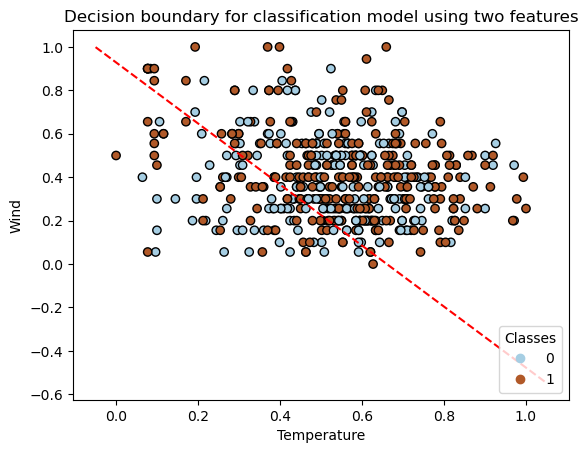

In [59]:
# YOUR CODE HERE

# We need to scale our observations, using the same scaler as before:
X_forest_2_scaled = scaler_f2.transform(X_forest_2)

# Now we create our plot
fig, ax = plt.subplots()

# Scatter plot of temperature and wind (scaled), colored by their class
scatter = ax.scatter(
            X_forest_2_scaled[:,0],  # values of temperature on x-axis
            X_forest_2_scaled[:,1],  # values of wind on y-axis
            c=forest_fire['class'].values,  # color class by class 
            edgecolors='k',        # black edge colors
            cmap=plt.cm.Paired)    # color of markers: Paired colormap 

# Plot decision boundary 
x_vals_f2 = np.array(ax.get_xlim())    # array with x-axis limits
y_vals_f2 = -(model_f2.intercept_[0]+x_vals_f2*model_f2.coef_[0][0])/model_f2.coef_[0][1]  # equation of decision boundary
plt.plot(x_vals_f2, y_vals_f2, '--', c="red")  # plot decision boundary in red color

# Add labels, title, and legend
plt.xlabel('Temperature')
plt.ylabel('Wind')
plt.title('Decision boundary for classification model using two features')
plt.legend(*scatter.legend_elements(),loc="lower right", title="Classes")

# Display plot
plt.show()


Most observations lie above the decision boundary line: as discussed above, our classifier will predict class 1 for most observations. 

### Multi-features logistic regression

We will try to improve the accuracy of our previous classifier using more features, namely: 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'

- Extract your new features of interest

In [46]:
# YOUR CODE HERE

X_forest = forest_fire[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]
y_forest = forest_fire[['class']] #Already defined above so not necessary if you run the whole notebook

- Split you data intro training and test set, using 20% of observations for the test set:

In [47]:
# YOUR CODE HERE

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_forest, y_forest, 
                                                            test_size=0.2, 
                                                            random_state=9, 
                                                            shuffle=True)

- Rescale your data, using the scaler of your choice:

In [48]:
# YOUR CODE HERE

# Define the scaler
scaler_f = MinMaxScaler()

# Fit the scaler
scaler_f.fit(X_train_f) 

# Transform the train and the test set
X_train_f = scaler_f.transform(X_train_f)
X_test_f = scaler_f.transform(X_test_f)

- Build and train a logistic regression classifier

In [49]:
# YOUR CODE HERE

# Set up our model
model_f = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)

# Fit our model
model_f.fit(X_train_f, y_train_f.values.flatten())

LogisticRegression(max_iter=1000)

- Extract the weights of your model in a dataframe

In [50]:
# Dataframe with the intercept and coefficients (weights) of the model
model_f_coeff = pd.DataFrame(np.concatenate((model_f.intercept_, model_f.coef_.flatten())), 
                     index=["Intercept"] + list(X_forest.columns.values),
                     columns=['Coefficients logistic classifier'])
model_f_coeff

,Coefficients logistic classifier
Intercept,-0.732410
FFMC,0.250480
DMC,-0.152404
DC,0.624889
ISI,-0.272978
temp,0.261000
RH,-0.177990
wind,0.559687
rain,0.204369


- Compare the training and testing accuracy of your model. What do you think?

In [51]:
# YOUR CODE HERE

# Compute accuracy
print('Accuracy of classifier on test set: {:.2f}'
     .format(model_f.score(X_test_f, y_test_f)))
print('Accuracy of classifier on training set: {:.2f}'
     .format(model_f.score(X_train_f, y_train_f)))

Accuracy of classifier on test set: 0.58
Accuracy of classifier on training set: 0.56


By using additional features, our accuracy improved. It is still not stellar, but at least better than a naive classifier...

- Plot the confusion matrix

In [52]:
# YOUR CODE HERE

# Predict on test set
y_pred_f = model_f.predict(X_test_f)

# Heatmap of confusion matrix
sns.heatmap(confusion_matrix(y_test_f, y_pred_f), annot=True, cmap='Blues', fmt='.4g')
plt.xlabel('Predicted label')
plt.ylabel('True labels')
plt.title('Confusion Matrix');

- Compute the precision, recall, and f1 score of class 1:

In [53]:
# YOUR CODE HERE

print('The precision for class 1 is: {:0.3f}'.format(precision_score(y_test_f, y_pred_f)))
print('The recall for class 1 is: {:0.3f}'.format(recall_score(y_test_f, y_pred_f)))
print('The F1 score for class 1 is: {:0.3f}'.format(f1_score(y_test_f, y_pred_f)))

The precision for class 1 is: 0.560
The recall for class 1 is: 0.792
The F1 score for class 1 is: 0.656


The precision increased and the recall decreased. In other words, our classifier is less inclined to predict class 1: it got better at identifying class 0 but a bit worse at identifying class 1. Although the overall accuracy improved, this could be problematic if our focus is on avoiding false negative (class 1 predicted but actual value is class 0).

### Improve the accuracy (optional)

Your goal is now to try to improve the accuracy of your model. Try to implement cross-validation techniques, different regularization and scaling, or even new features (e.g., encoding the month feature).

In [54]:
## Preprocessing

# Extract features of interest: we will also use the month
X_forest_m = forest_fire[['month','FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]
y_forest = forest_fire[['class']]

# Split training/test set
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_forest_m, y_forest, 
                                                            test_size=0.2, 
                                                            random_state=9, 
                                                            shuffle=True)

# Encode month using LabelEncoder
forest_month = X_train_m[['month']].values.ravel()
forest_month_test = X_test_m[['month']].values.ravel()
le = LabelEncoder()     # Define the encoder
le.fit(forest_month)    # Fit the encoder
#Transform the train and the test set
X_train_m = X_train_m.assign(month=le.transform(forest_month))
X_test_m = X_test_m.assign(month=le.transform(forest_month_test))

# Scaling
scaler_m = MinMaxScaler()    # Define the scaler
scaler_m.fit(X_train_m)      # Fit the scaler
X_train_m = scaler_m.transform(X_train_m)
X_test_m = scaler_m.transform(X_test_m)

In [55]:
## Model design and training

# Set up our model
model_m = LogisticRegressionCV(penalty='l2', solver='lbfgs', cv=5, max_iter=1000)

# Fit our model
model_m.fit(X_train_m, y_train_m.values.flatten())

LogisticRegressionCV(cv=5, max_iter=1000)

Accuracy of classifier on test set: 0.58
Accuracy of classifier on training set: 0.54
The precision for class 1 is: 0.549
The recall for class 1 is: 0.943
The F1 score for class 1 is: 0.694


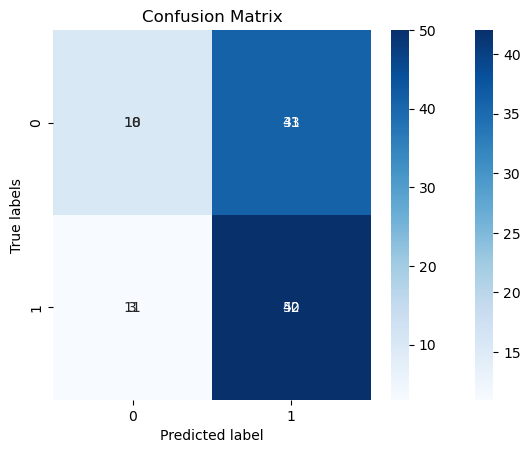

In [56]:
## Evaluation

# Compute accuracy
print('Accuracy of classifier on test set: {:.2f}'
     .format(model_m.score(X_test_m, y_test_m)))
print('Accuracy of classifier on training set: {:.2f}'
     .format(model_m.score(X_train_m, y_train_m)))

# Predict on test set
y_pred_m = model_m.predict(X_test_m)

# Other metrics
print('The precision for class 1 is: {:0.3f}'.format(precision_score(y_test_m, y_pred_m)))
print('The recall for class 1 is: {:0.3f}'.format(recall_score(y_test_m, y_pred_m)))
print('The F1 score for class 1 is: {:0.3f}'.format(f1_score(y_test_m, y_pred_m)))

# Heatmap of confusion matrix
sns.heatmap(confusion_matrix(y_test_m, y_pred_m), annot=True, cmap='Blues', fmt='.4g')
plt.xlabel('Predicted label')
plt.ylabel('True labels')
plt.title('Confusion Matrix');
plt.show()